# Written by B.SasiVatsal on 02-02-2022

In [430]:
# importing all the required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import difflib
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
# for plots to work in jupyter have to live with these line...smh...
%matplotlib inline

In [431]:
# reading the data set using .read_csv method in pandas and storing it in a data frame
movies_dataframe = pd.read_csv("movie_dataset.csv")
# for collabrative learning
cmovies_dataframe = pd.read_csv("ratings.csv")
# Pandas head() method is used to return top n (5 by default) rows of a data frame or series.
movies_dataframe.head()
# checking the size of the data set 
movies_dataframe.shape
# There are total of 4803 rows with 24 feature coloumns
movies_dataframe.info()
# Pandas dataframe.info() function is used to get a concise summary of the dataframe. 
# It comes really handy when doing exploratory analysis of the data. 
# To get a quick overview of the dataset we use the dataframe.info() function.
# converting float64 popularity to str object
movies_dataframe['popularity'] = movies_dataframe['popularity'].astype(str)
movies_dataframe['revenue'] = movies_dataframe['revenue'].astype(str)
movies_dataframe['budget'] = movies_dataframe['budget'].astype(str)
movies_dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [432]:
# selecting only those features that define our recommender system
# This helps our model to shortlist the selection and predict more accurately
#defining_features = ["popularity","genres", "keywords", "tagline","director","overview","vote_average","vote_count"]
# I selected genres, keywords, tagline, cast and director as my main priority remaining other 
# 19 feature coloumns are left out execept these 5 coloumns
defining_features = ['keywords','cast','genres','director','popularity','tagline','overview']


In [433]:
# Pandas dataframe.isna() function is used to detect missing values. It return a boolean same-sized object indicating if the values are NA.
movies_dataframe[defining_features].isna()
# sns.heatmap(movies_dataframe[defining_features].isna(), cbar=False, yticklabels=False)

,keywords,cast,genres,director,popularity,tagline,overview
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
4798,False,False,False,False,False,False,False
4799,True,False,False,False,False,False,False
4800,False,False,False,False,False,True,False
4801,True,False,True,False,False,False,False


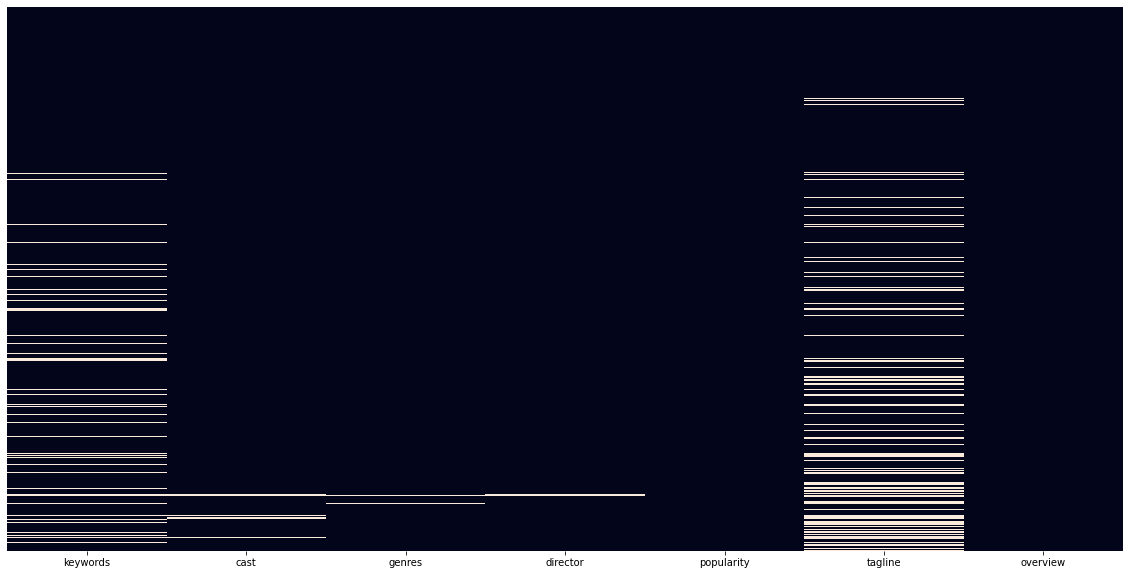

In [434]:
# Generating heatmaps to check for null values in the data frame

# The figsize attribute allows us to specify the width and height of a figure in unit inches
plt.figure(figsize=(20,10))
sns.heatmap(movies_dataframe[defining_features].isna(), cbar=False, yticklabels=False)
# there are null values in few columns that should be taken care of
updated_movies_dataframe = movies_dataframe[defining_features].fillna("")
# Just like pandas dropna() method manage and remove Null values from a data frame, fillna() manages and replaces NaN values with some value of their own.

,keywords,cast,genres,director,popularity,tagline,overview
0,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...,Action Adventure Fantasy Science Fiction,James Cameron,150.437577,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di..."
1,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...,Adventure Fantasy Action,Gore Verbinski,139.082615,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha..."
2,spy based on novel secret agent sequel mi6,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Action Adventure Crime,Sam Mendes,107.376788,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...
3,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...,Action Crime Drama Thriller,Christopher Nolan,112.31295,The Legend Ends,Following the death of District Attorney Harve...
4,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Action Adventure Science Fiction,Andrew Stanton,43.926995,"Lost in our world, found in another.","John Carter is a war-weary, former military ca..."
...,...,...,...,...,...,...,...
4798,united states\u2013mexico barrier legs arms pa...,Carlos Gallardo Jaime de Hoyos Peter Marquardt...,Action Crime Thriller,Robert Rodriguez,14.269792,"He didn't come looking for trouble, but troubl...",El Mariachi just wants to play his guitar and ...
4799,,Edward Burns Kerry Bish\u00e9 Marsha Dietlein ...,Comedy Romance,Edward Burns,0.642552,A newlywed couple's honeymoon is upended by th...,A newlywed couple's honeymoon is upended by th...
4800,date love at first sight narration investigati...,Eric Mabius Kristin Booth Crystal Lowe Geoff G...,Comedy Drama Romance TV Movie,Scott Smith,1.444476,,"""Signed, Sealed, Delivered"" introduces a dedic..."
4801,,Daniel Henney Eliza Coupe Bill Paxton Alan Ruc...,,Daniel Hsia,0.857008,A New Yorker in Shanghai,When ambitious New York attorney Sam is sent t...


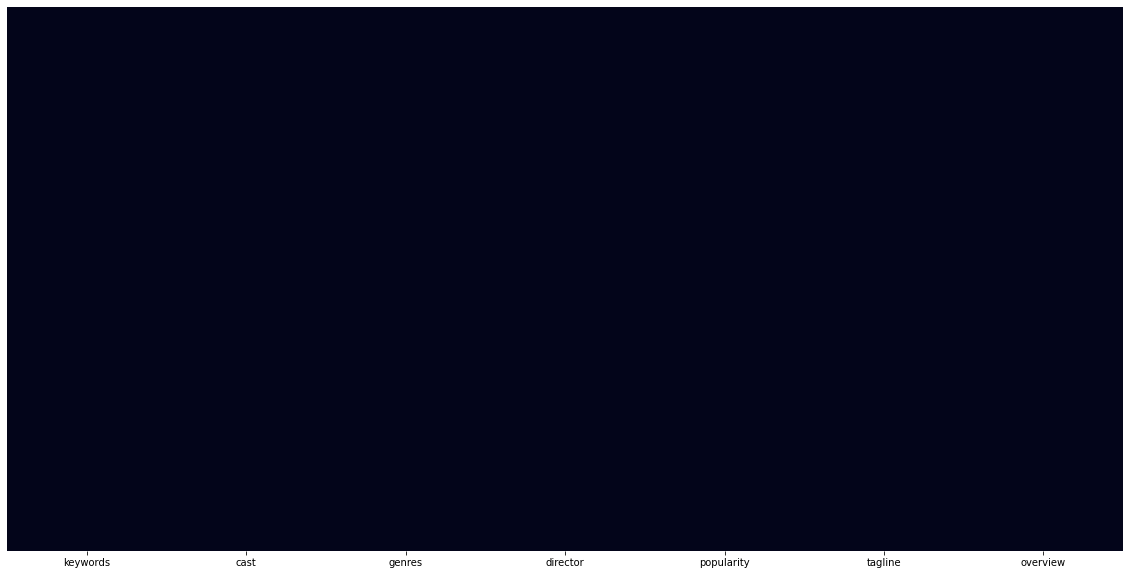

In [435]:
# Checking again if there are any null values using heatmap
plt.figure(figsize=(20,10))
sns.heatmap(updated_movies_dataframe[defining_features].isna(), cbar=False, yticklabels=False)
# There are no lines in the heatmap so all the NULL values in our desired cols are removed.
# so filling the null values with null string is successful

# Checking the updated data set
updated_movies_dataframe

In [436]:
# .columns attribute return the column labels of the given Dataframe, which will be taking it into a variablefeatures_in_col
features_in_col = ''
for col_feature in updated_movies_dataframe.columns:
    features_in_col+=updated_movies_dataframe[col_feature]

features_in_col
# Next we will be using concept of vectorizer to convert the text into numerical data
# it is explained briefly in the next cell

0       culture clash future space war space colony so...
1       ocean drug abuse exotic island east india trad...
2       spy based on novel secret agent sequel mi6Dani...
3       dc comics crime fighter terrorist secret ident...
4       based on novel mars medallion space travel pri...
                              ...                        
4798    united states\u2013mexico barrier legs arms pa...
4799    Edward Burns Kerry Bish\u00e9 Marsha Dietlein ...
4800    date love at first sight narration investigati...
4801    Daniel Henney Eliza Coupe Bill Paxton Alan Ruc...
4802    obsession camcorder crush dream girlDrew Barry...
Name: keywords, Length: 4803, dtype: object

# Vectorizer Concept
</br>
--> TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.
</br></br>
--> Simply TF-IDF is a measure of originality of a word by comparing the no.of times a word appears with no.of times a word appears in the doc with the no.of docs the word appears in.It is usually used by some search engines to help them obtain better results which are more relevant to a specific query.\ 
</br></br>
--> So then TF-IDF is a score which is applied to every word in every document in our dataset. And for every word, the TF-IDF value increases with every appearance of the word in a document, but is gradually decreased with every appearance in other documents. And the maths for that is in the next section.


In [437]:
# intializing the tifidvectorizer engine from sklearn.feature_extraction.text
v = TfidfVectorizer()
cv = CountVectorizer()
# Transforming the data using fit_transform() so that we can scale the training data and also learn the scaling parameters of that data
transformed_features = cv.fit_transform(features_in_col)
# checking transformed features
print(transformed_features)
# .fit_transform() will calculate the mean(μ) and standard deviation(σ) of the feature F at a time it will transform the data points of the feature F.

  (0, 14101)	1
  (0, 12033)	1
  (0, 20607)	1
  (0, 41285)	2
  (0, 46836)	1
  (0, 12441)	1
  (0, 41034)	1
  (0, 48065)	1
  (0, 48604)	1
  (0, 38765)	1
  (0, 40431)	1
  (0, 47149)	1
  (0, 41928)	1
  (0, 27369)	1
  (0, 30562)	1
  (0, 37847)	1
  (0, 5689)	1
  (0, 18718)	1
  (0, 39316)	1
  (0, 19245)	1
  (0, 10643)	1
  (0, 2553)	1
  (0, 43564)	3
  (0, 48028)	1
  (0, 32996)	1
  :	:
  (4802, 17828)	1
  (4802, 39527)	1
  (4802, 13322)	1
  (4802, 25671)	1
  (4802, 10050)	1
  (4802, 16602)	2
  (4802, 8170)	3
  (4802, 37736)	1
  (4802, 19499)	1
  (4802, 20526)	1
  (4802, 21885)	1
  (4802, 7297)	1
  (4802, 14727)	1
  (4802, 39032)	1
  (4802, 7281)	1
  (4802, 14025)	2
  (4802, 19028)	1
  (4802, 21646)	1
  (4802, 10622)	1
  (4802, 1675)	1
  (4802, 21250)	1
  (4802, 23160)	3
  (4802, 16807)	1
  (4802, 23161)	1
  (4802, 4896)	1


In [438]:
# checking for similarity using cosine_similarity method from/in sklearn.metrics.pairwise
relation_similarity = cosine_similarity(transformed_features)
# Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. 
# checking the similarity
print(relation_similarity)

[[1.         0.3548745  0.22537447 ... 0.30361336 0.20058064 0.13154093]
 [0.3548745  1.         0.32577918 ... 0.40125589 0.30926898 0.18438075]
 [0.22537447 0.32577918 1.         ... 0.25018512 0.17799766 0.16979054]
 ...
 [0.30361336 0.40125589 0.25018512 ... 1.         0.29117316 0.17155008]
 [0.20058064 0.30926898 0.17799766 ... 0.29117316 1.         0.21722293]
 [0.13154093 0.18438075 0.16979054 ... 0.17155008 0.21722293 1.        ]]


In [439]:
# taking input from the user for his fav movie
while True:
    user_fav_movie = input("Whats that movie which revolves always in you're head? : ")
    close_match = difflib.get_close_matches(user_fav_movie, list(movies_dataframe['title']))
    if not close_match:
        print("Error! couldn't find movie with that name...Try again..")
    else:
        # searching for the movie entered by user in movies_dataframe using difflib.get_close_matches method
        # difflib.get_close_matches method is used to select/search the possible close good enough matches of input string into list of pattern strings.
        close_match = difflib.get_close_matches(user_fav_movie, list(movies_dataframe['title']))
        break
# as 1t result in the list is more probable , i'll consider that result only
close_match = close_match[0]
print(close_match)
# good it works as intened,we can also give another arument cutoff which ranges from 0-1, Possibilities that don’t score at least that similar to word , i don't think its necessary are ignored.

Whats that movie which revolves always in you're head? : 300
300


In [440]:
index_of_movie = movies_dataframe[movies_dataframe['title']==close_match]['index'].values[0]
print(index_of_movie)
# Model is almost near to completion, now we can find similar movies matching to the user input movie
# enumerate helps us to keep track of the index of the element, so that we can acess them later for printing similar moves
similar_movies_list = list(enumerate(relation_similarity[index_of_movie]))
# printing the list of similar movies 
print
(similar_movies_list)
# there are more that 1k+ similar movies, we'll sort and shortlist them accordingly
# lambda code copied from stackoverflow...coz that's what programmer do
sorted_similar_movies = sorted(similar_movies_list, key = lambda x:x[1], reverse=True)
sorted_similar_movies

687


[(687, 1.0000000000000002),
 (253, 0.6324555320336759),
 (3432, 0.6100598766941157),
 (1953, 0.5698754403312282),
 (160, 0.5627440368976198),
 (847, 0.560868747080634),
 (3229, 0.558265866218918),
 (59, 0.5577825627278402),
 (599, 0.5540283101259831),
 (4062, 0.5538616819773351),
 (3192, 0.5524769399991001),
 (379, 0.5522524410273708),
 (274, 0.5512709166902029),
 (3802, 0.5508844563159558),
 (1004, 0.547356176720907),
 (3776, 0.5466666666666665),
 (329, 0.5459062240368548),
 (48, 0.5449416238374142),
 (3899, 0.5435605435608153),
 (2724, 0.5428576649955718),
 (19, 0.5408203462188463),
 (2386, 0.5400872776838235),
 (230, 0.539328621824246),
 (1390, 0.5390884456202506),
 (229, 0.5371967152550627),
 (1984, 0.5366563145999494),
 (3072, 0.5361780822329306),
 (310, 0.5360749872752716),
 (4383, 0.5359791957383723),
 (1985, 0.5351110722542776),
 (156, 0.5314796216557076),
 (2729, 0.5312590183501014),
 (2900, 0.5308070247848794),
 (549, 0.5295657301440071),
 (3471, 0.5293792820298355),
 (3427, 

In [441]:
movie_title_index_ls = []
# Selecting the Top 10 similar movies
for i in range(15):
    # appending only indices and not the probablties
    movie_title_index_ls.append(sorted_similar_movies[i][0])
del movie_title_index_ls[0] 
print(movie_title_index_ls)

[253, 3432, 1953, 160, 847, 3229, 59, 599, 4062, 3192, 379, 274, 3802, 1004]


In [442]:
movie_titles_list=[]
for index in movie_title_index_ls:
    movie_titles_list.append(movies_dataframe[movies_dataframe['index'] == index]['title'].values[0])
    print(movies_dataframe[movies_dataframe['index'] == index]['title'].values[0])

300: Rise of an Empire
The Work and the Glory II: American Zion
Ironclad
How to Train Your Dragon 2
Semi-Pro
Quo Vadis
2012
Hart's War
The Best Years of Our Lives
Two Evil Eyes
Conan the Barbarian
Gladiator
1776
The Boat That Rocked


# It Works bixch